I wanted to make a Time Series Forecast Analysis of Take-Two Interactive Software, Inc. (TTWO) for the last 9 years (from 1/1/2010 to 1/1/2020) Data taken from https://finance.yahoo.com/

In [1]:
from datetime import datetime
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np


# Plotting imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Setting default figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10


# Forecasting Imports
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR,ARResults
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.arima import auto_arima

from prophet import Prophet



# Math/Error metrics imports
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from math import sqrt

In [2]:
# Loading training set CSV file with index = date 
df = pd.read_csv('data/finance.yahoo.com-TTWO.csv',index_col='Date',parse_dates= True)
# Dropping columns not needed
TTWO = df.drop(columns= ['Open','High','Low','Close','Volume'])
# Loading Validation set
valid = pd.read_csv('data/finance.yahoo.com-TTWO-validation.csv',index_col='Date',parse_dates= True).drop(columns= ['Open','High','Low','Close','Volume'])

In [3]:
# Displaying dataframe
TTWO.info()
TTWO

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


,Adj Close
Date,
2010-01-04,10.400000
2010-01-05,10.470000
2010-01-06,10.440000
2010-01-07,10.390000
2010-01-08,10.420000
...,...
2019-12-24,123.930000
2019-12-26,123.989998
2019-12-27,124.470001


In [4]:
# Checking if the datetime is index values
TTWO.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=2516, freq=None)

In [5]:
# Aaggregating the data by month (averaging the values by month)
TTWO_weekly =TTWO.resample('W').mean()
# Displaying dataframe
TTWO_weekly

,Adj Close
Date,
2010-01-10,10.424000
2010-01-17,10.292000
2010-01-24,9.585000
2010-01-31,9.242000
2010-02-07,9.364000
...,...
2019-12-08,122.700001
2019-12-15,122.368000
2019-12-22,122.634000


In [6]:
# Aaggregating the data by month (averaging the values by month)
TTWO_monthly =TTWO.resample('MS').mean()
# Displaying dataframe
TTWO_monthly

valid_monthly = valid.resample('MS').mean()

In [7]:
yearly = TTWO_monthly.groupby(pd.Grouper(freq ='A'))
yearly.describe()
# yearly.head()

Adj Close                                                \
               count        mean        std        min         25%   
Date                                                                 
2010-12-31      12.0   10.275100   0.843548   9.000455    9.810833   
2011-12-31      12.0   14.386680   1.308214  11.916087   13.640714   
2012-12-31      12.0   12.308719   2.384168   9.181905   10.558716   
2013-12-31      12.0   16.155247   1.660358  12.361429   15.492977   
2014-12-31      12.0   22.053001   2.873569  17.893809   20.500357   
2015-12-31      12.0   29.245201   3.316590  24.873809   27.362658   
2016-12-31      12.0   40.185929   5.373694  33.342105   36.077630   
2017-12-31      12.0   80.625733  22.300738  51.733000   59.634136   
2018-12-31      12.0  115.752131  10.267440  98.018095  110.683497   
2019-12-31      12.0  111.607943  13.554261  92.666667  101.390910   

                                                
                   50%         75%         max  
Date                                            
2010-12-31   10.112016   10.692929   12.190909  
2011-12-31   14.477083   15.351076   16.277143  
2012-12-31   11.915988   14.665750   15.750455  
2013-12-31   16.149545   17.365098   18.424545  
2014-12-31   21.572143   22.909865   27.820000  
2015-12-31   28.993191   30.462500   35.638636  
2016-12-31   38.961955   44.600119   49.323809  
2017-12-31   76.012318  101.040568  114.777143  
2018-12-31  115.102857  123.900435  133.108422  
2019-12-31  114.602931  122.385052  128.281000

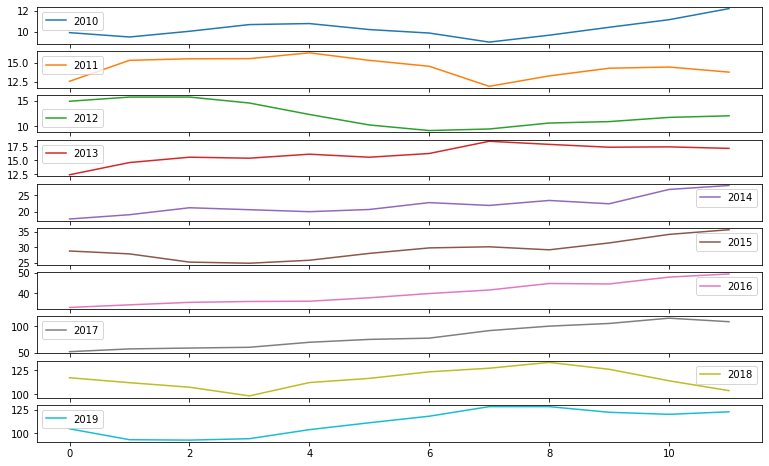

In [8]:
# Create a new DataFrame and store yearly values in columns 
TTWO_annual = pd.DataFrame()

# For loop to group each year separately amd adding it to empty dataframe
for yr, group in yearly:
    TTWO_annual[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
TTWO_annual.plot(figsize = (13,8), subplots=True, legend=True);

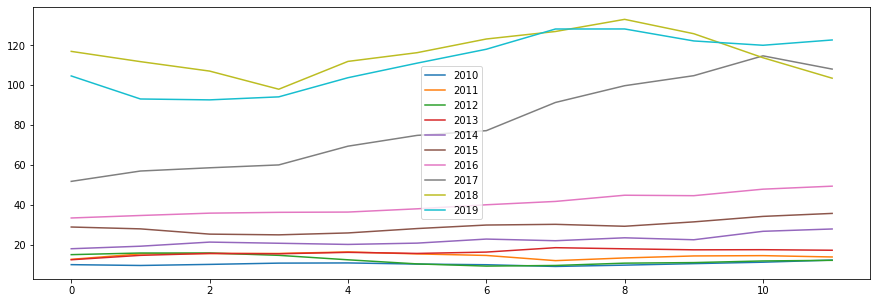

In [9]:
# Plot overlapping yearly groups 
TTWO_annual.plot(figsize = (15,5), subplots=False, legend=True,grid=False);

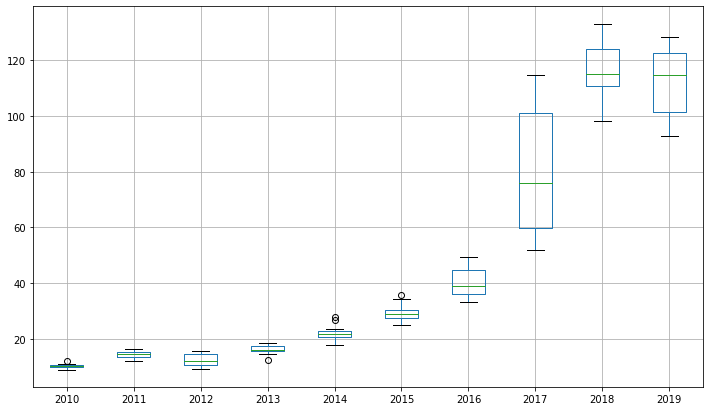

In [10]:
# BoxPlot by year
TTWO_annual.boxplot(figsize = (12,7));

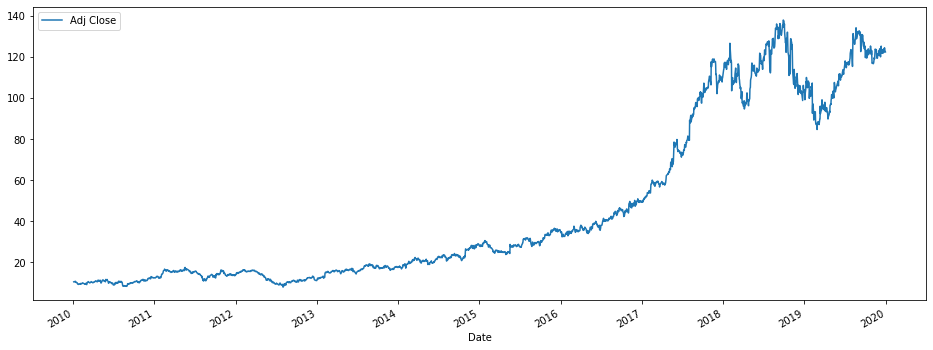

In [11]:
# Plot of complete data
TTWO.plot(figsize = (16,6));

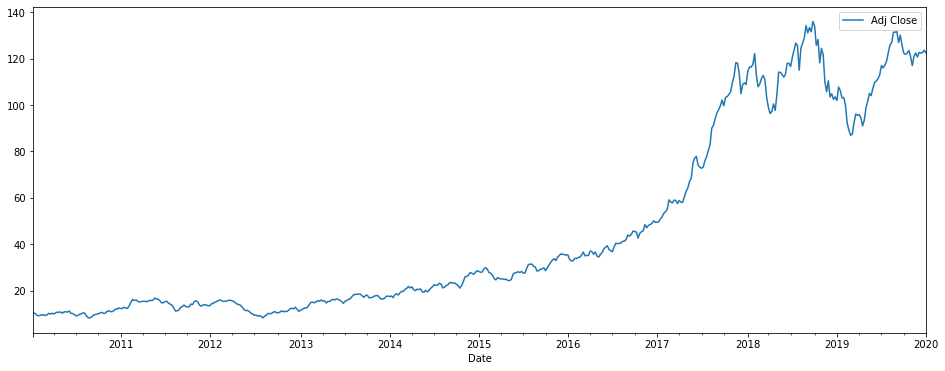

In [12]:
# Plot of Averge data by week
TTWO_weekly.plot(figsize = (16,6));

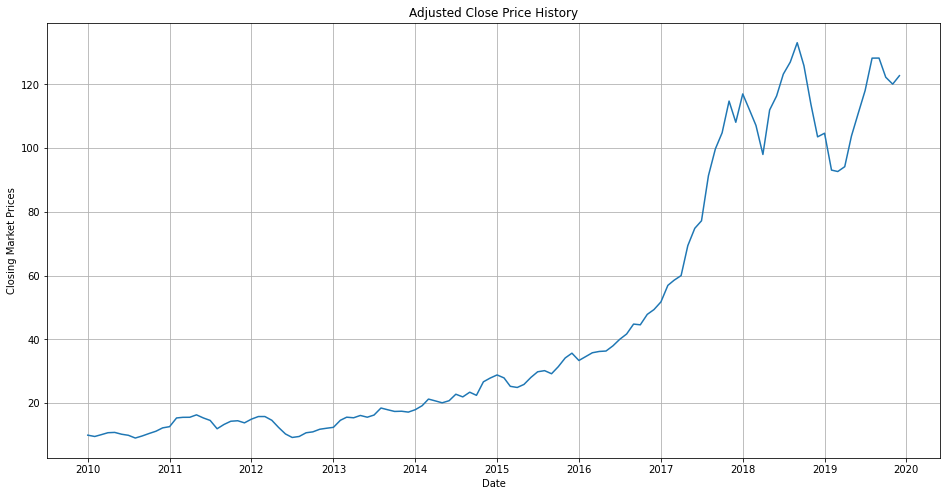

In [13]:
# Plot of Averge data by month
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Market Prices')
plt.title('Adjusted Close Price History')
plt.plot(TTWO_monthly['Adj Close'])
plt.show()

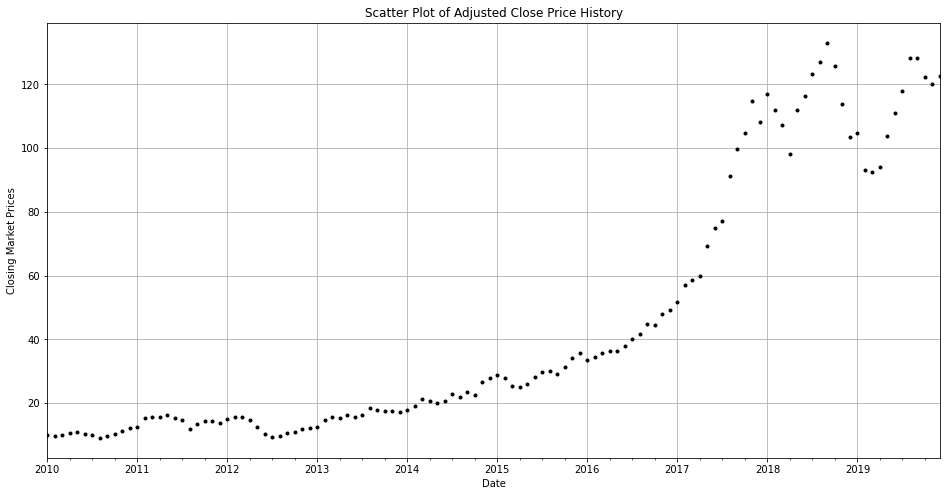

In [14]:
# Scatter Plot of Averge data by month
plt.figure(figsize=(16,8))
TTWO_monthly['Adj Close'].plot(style='k.',)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Market Prices')
plt.title('Scatter Plot of Adjusted Close Price History')
plt.show() 

In [15]:
# # Filtering DataFrames to only include dates from 2015
# TTWO_filtered = TTWO.loc['2015-01-01':]
# sns.distplot(TTWO_filtered['Adj Close'], hist=True, kde=True,bins=8)

C:\Users\sdman\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sdman\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Adj Close', ylabel='Density'>

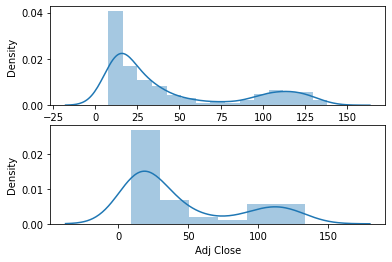

In [16]:
plt.subplot(211)
sns.distplot(TTWO['Adj Close'], hist=True, kde=True)
plt.subplot(212)
sns.distplot(TTWO_monthly['Adj Close'], hist=True, kde=True)

This Density Plot shows the data is not normally distributed. I will need to transform and/or apply differential operations

Null hypothesis: series is stationary


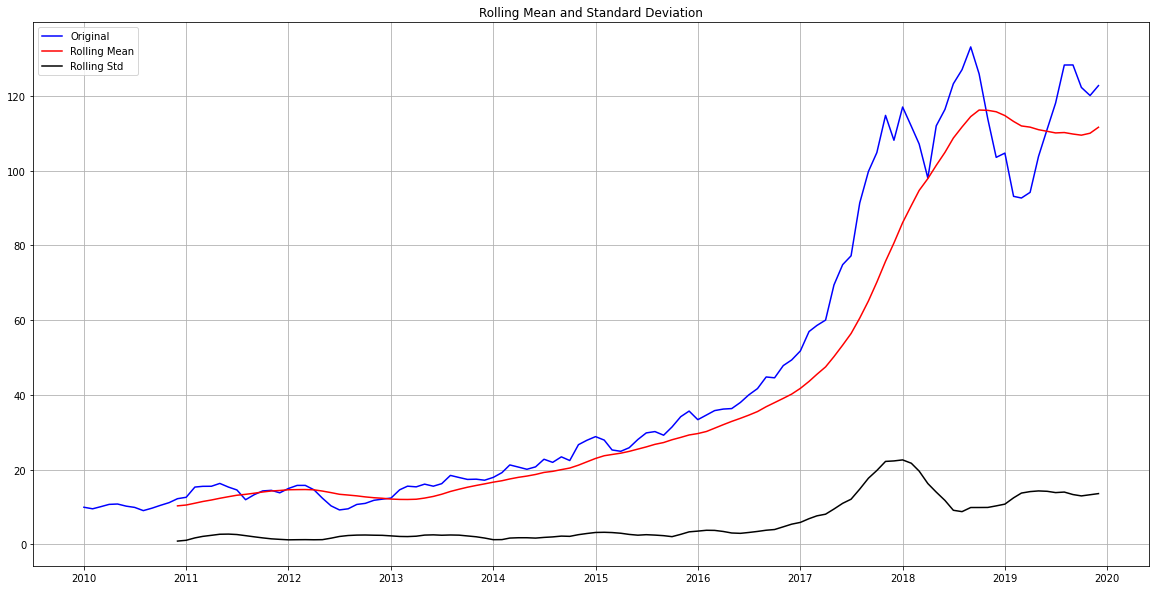

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics                  0.544195
p-value                          0.986156
No. of Lags Used                13.000000
Number of observations used    106.000000
critical value (1%)             -3.493602
critical value (5%)             -2.889217
critical value (10%)            -2.581533
dtype: float64


In [17]:
# Testing for staionarity

def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Plot rolling statistics:
    plt.figure(figsize=(20,10))
    plt.grid(True)
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # Augmented Dickey Fuller Test (Most commonly used)
    print("Results of Augmented Dickey Fuller(ADF) Test:")
    print('Null Hypothesis: The series has a unit root (value of a =1)\nAlternate Hypothesis: The series has no unit root.\n')
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    adft_output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of Lags Used','Number of observations used'])
    for key,values in adft[4].items():
        adft_output['critical value (%s)'%key] =  values
    print(adft_output)
    
#     # Kwiatkowski-Phillips-Schmidt-Shin Test (Less commonly used)
#     print ('\n\nResults of Kwiatkowski-Phillips-Schmidt-Shin(KPSS) Test:')
#     print('Null Hypothesis: The process is trend stationary.\nAlternate Hypothesis: The series has a unit root (series is not stationary).\n')
#     kpsstest = kpss(timeseries, regression='c')
#     kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','No. of Lags Used'])
#     for key,value in kpsstest[3].items():
#         kpss_output['Critical Value (%s)'%key] = value
#     print (kpss_output)
    
test_stationarity(TTWO_monthly['Adj Close'])

Dick Augmented Dickey Fuller(ADF) Test:

test statistic greater then critical value, which implies that the time series is not stationary

p-value is almost at 1.0 (p-value is greater than 0.05(alpha)) showing again that the time series is not stationary

Kwiatkowski-Phillips-Schmidt-Shin(KPSS) Test:


C:\Users\sdman\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Adj Close', ylabel='Density'>

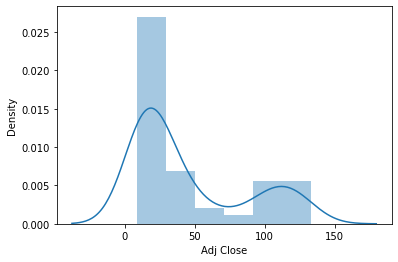

In [18]:
sns.distplot(TTWO_monthly['Adj Close'], hist=True, kde=True)

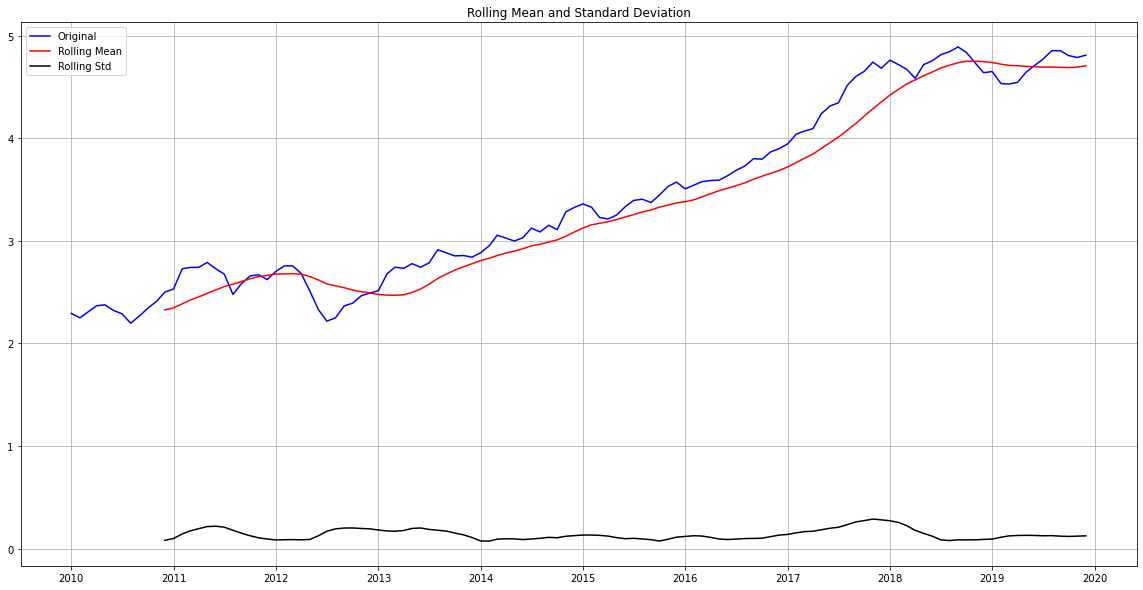

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics                 -0.311485
p-value                          0.923862
No. of Lags Used                 1.000000
Number of observations used    118.000000
critical value (1%)             -3.487022
critical value (5%)             -2.886363
critical value (10%)            -2.580009
dtype: float64


In [19]:
# Applying Log transformation to the Adj Close values
TTWO_monthly['natural_log'] = TTWO_monthly['Adj Close'].apply(lambda x: np.log(x))  
test_stationarity(TTWO_monthly['natural_log'].dropna(inplace=False))

C:\Users\sdman\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='natural_log', ylabel='Density'>

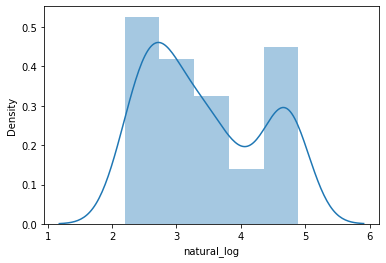

In [20]:
sns.distplot(TTWO_monthly['natural_log'], hist=True, kde=True)

This Density Plot still is not This Density Plot shows a normal distribution.

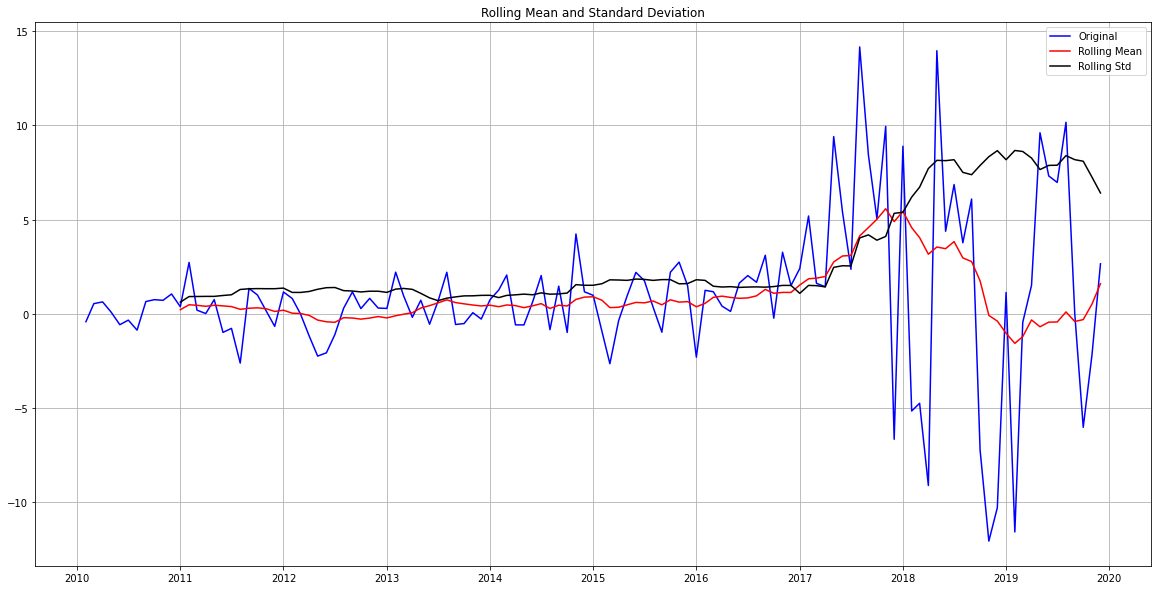

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics                 -2.351184
p-value                          0.155991
No. of Lags Used                12.000000
Number of observations used    106.000000
critical value (1%)             -3.493602
critical value (5%)             -2.889217
critical value (10%)            -2.581533
dtype: float64


In [21]:
# First Difference
TTWO_monthly['first_difference'] = TTWO_monthly['Adj Close'] - TTWO_monthly['Adj Close'].shift(1)  
test_stationarity(TTWO_monthly['first_difference'].dropna(inplace=False))

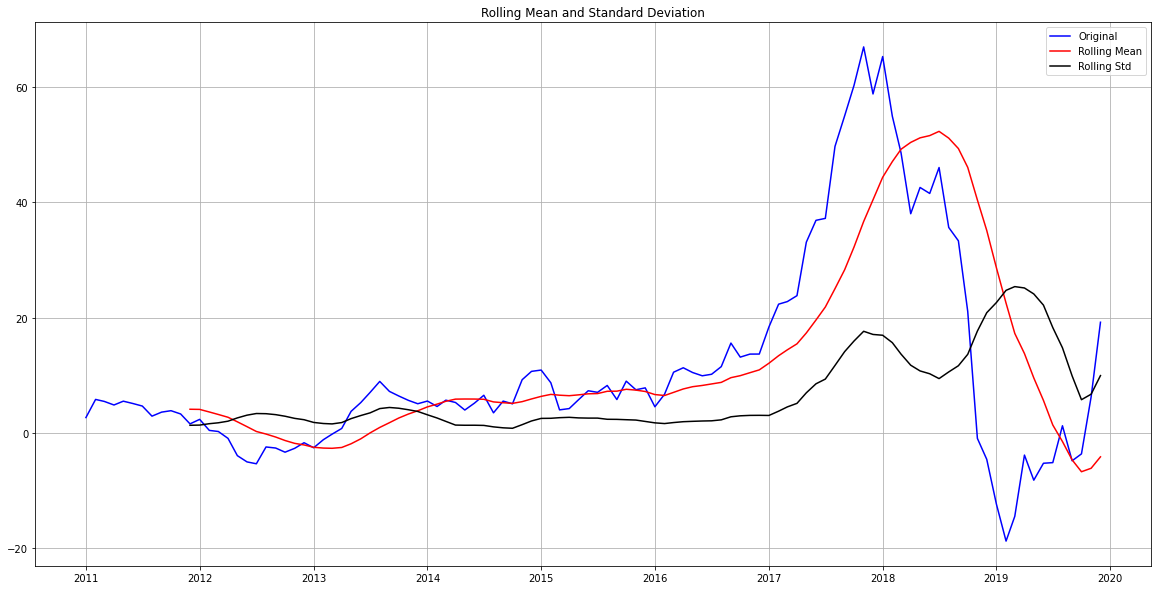

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics                -1.525511
p-value                         0.520856
No. of Lags Used               13.000000
Number of observations used    94.000000
critical value (1%)            -3.501912
critical value (5%)            -2.892815
critical value (10%)           -2.583454
dtype: float64


In [22]:
# Seasonal Difference
TTWO_monthly['seasonal_difference'] = TTWO_monthly['Adj Close'] - TTWO_monthly['Adj Close'].shift(12)
test_stationarity(TTWO_monthly['seasonal_difference'].dropna(inplace=False))

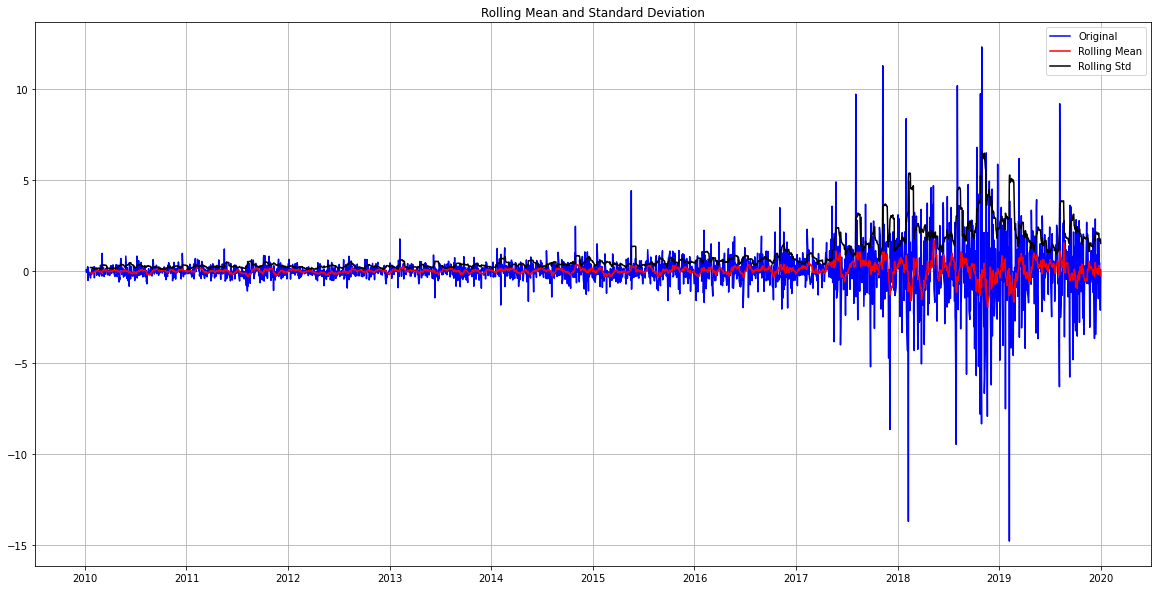

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics               -8.338456e+00
p-value                        3.224305e-13
No. of Lags Used               2.700000e+01
Number of observations used    2.487000e+03
critical value (1%)           -3.432982e+00
critical value (5%)           -2.862703e+00
critical value (10%)          -2.567389e+00
dtype: float64


In [23]:
# The first difference (shifting only 1)
TTWO['first_difference'] = TTWO['Adj Close'] - TTWO['Adj Close'].shift(1)  

test_stationarity(TTWO.first_difference.dropna(inplace=False))

C:\Users\sdman\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='first_difference', ylabel='Density'>

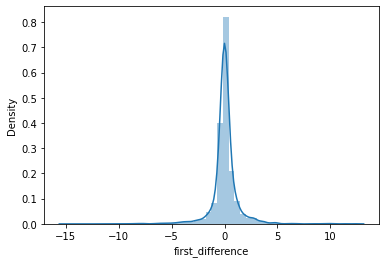

In [24]:
sns.distplot(TTWO['first_difference'].dropna(inplace=False), hist=True, kde=True)

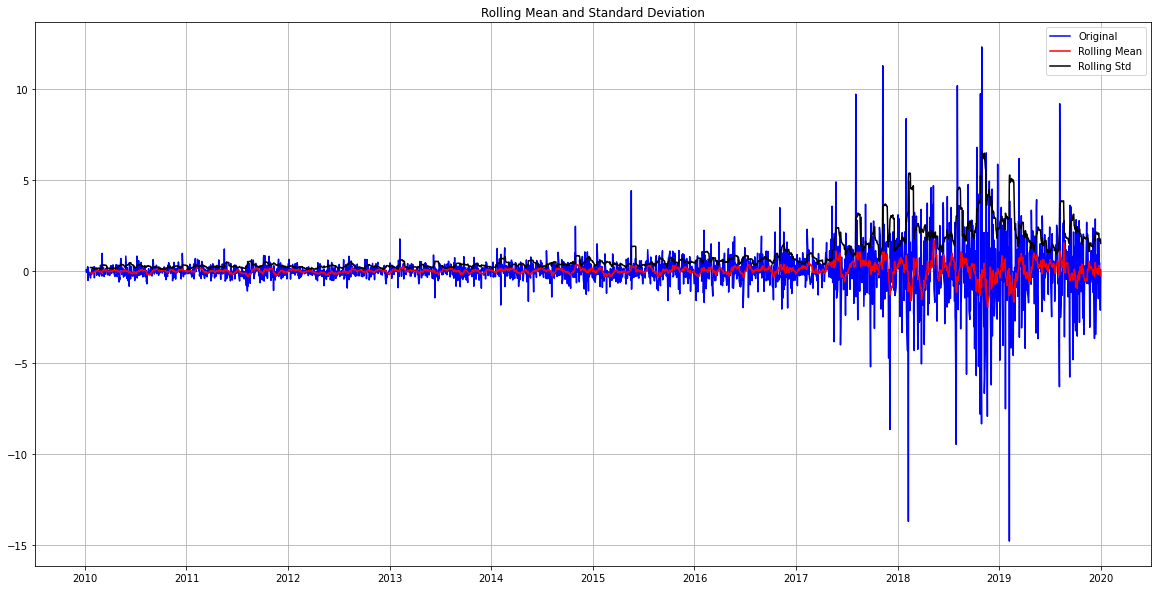

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics               -8.338456e+00
p-value                        3.224305e-13
No. of Lags Used               2.700000e+01
Number of observations used    2.487000e+03
critical value (1%)           -3.432982e+00
critical value (5%)           -2.862703e+00
critical value (10%)          -2.567389e+00
dtype: float64


In [25]:
# The first difference (shifting only 1)
TTWO_monthly['first_difference'] = TTWO_monthly['Adj Close'] - TTWO_monthly['Adj Close'].shift(1)  

test_stationarity(TTWO.first_difference.dropna(inplace=False))

C:\Users\sdman\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='first_difference', ylabel='Density'>

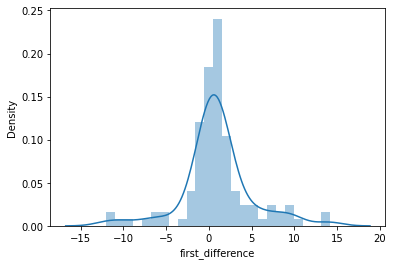

In [26]:
sns.distplot(TTWO_monthly['first_difference'].dropna(inplace=False), hist=True, kde=True)

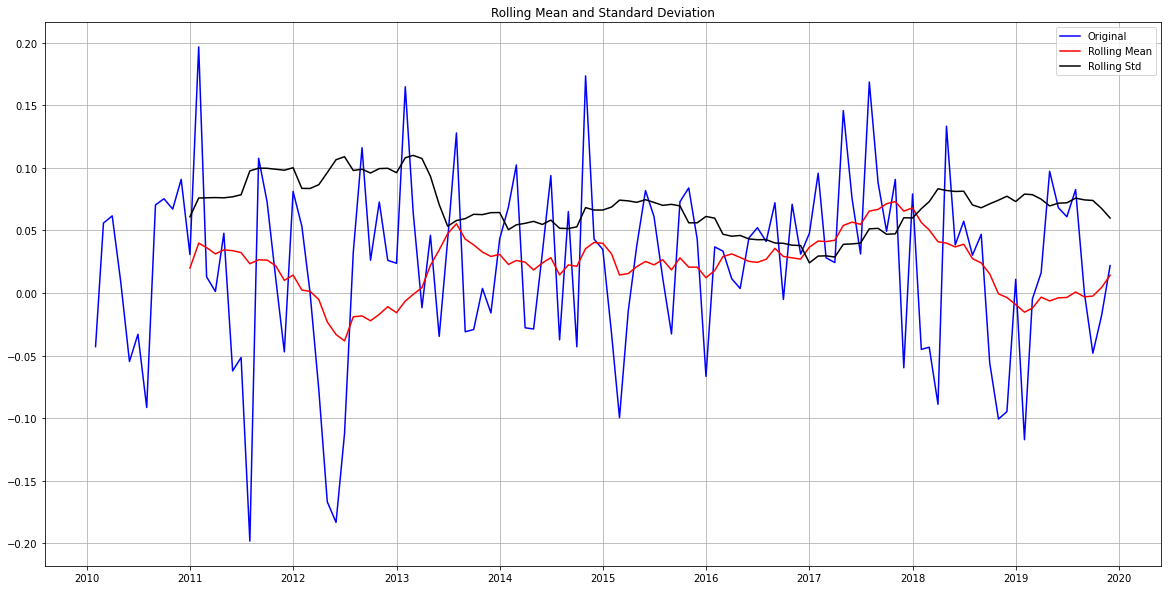

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics               -8.272842e+00
p-value                        4.742062e-13
No. of Lags Used               0.000000e+00
Number of observations used    1.180000e+02
critical value (1%)           -3.487022e+00
critical value (5%)           -2.886363e+00
critical value (10%)          -2.580009e+00
dtype: float64


In [27]:
# The log first difference by month (shifting only 1)
TTWO_monthly['log_first_difference'] = TTWO_monthly.natural_log - TTWO_monthly.natural_log.shift(1)  

test_stationarity(TTWO_monthly.log_first_difference.dropna(inplace=False))

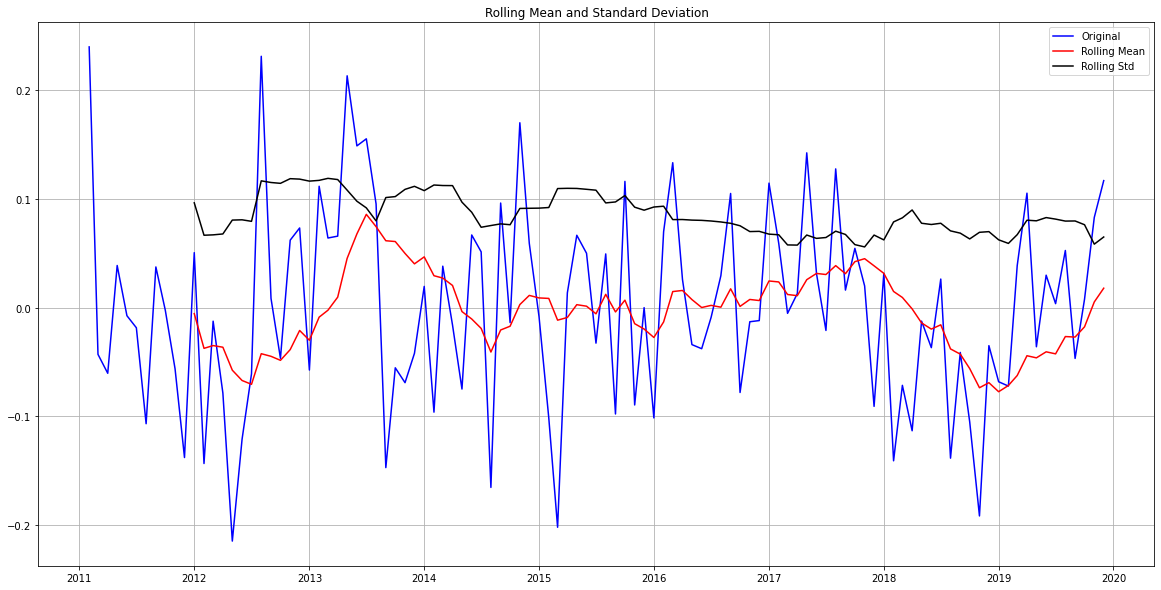

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics                -3.990280
p-value                         0.001462
No. of Lags Used               11.000000
Number of observations used    95.000000
critical value (1%)            -3.501137
critical value (5%)            -2.892480
critical value (10%)           -2.583275
dtype: float64


In [28]:
TTWO_monthly['log_seasonal_first_difference'] = TTWO_monthly.log_first_difference - TTWO_monthly.log_first_difference.shift(12)  

test_stationarity(TTWO_monthly.log_seasonal_first_difference.dropna(inplace=False))

Dick Augmented Dickey Fuller(ADF) Test:

test statistic less then critical value, which implies that the time series is finally stationary

p-value is Less than 0.05 (the accepted alpha value)

C:\Users\sdman\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_seasonal_first_difference', ylabel='Density'>

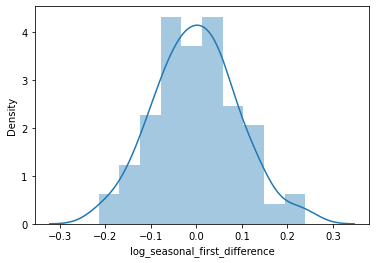

In [29]:
sns.distplot(TTWO_monthly['log_seasonal_first_difference'].dropna(inplace=False), hist=True, kde=True)

This Density Plot is shows a normal distribution.

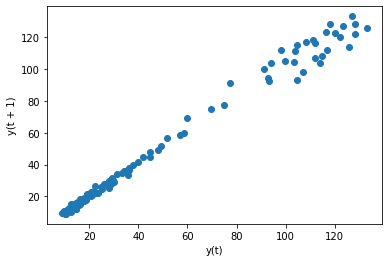

In [30]:
lag_plot(TTWO_monthly['Adj Close']);

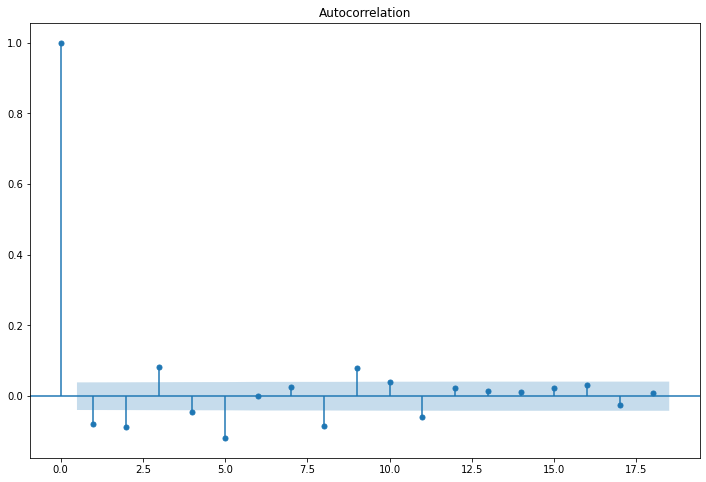

In [31]:
#ACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_acf(TTWO['first_difference'].iloc[1:], lags=18, ax=ax1)

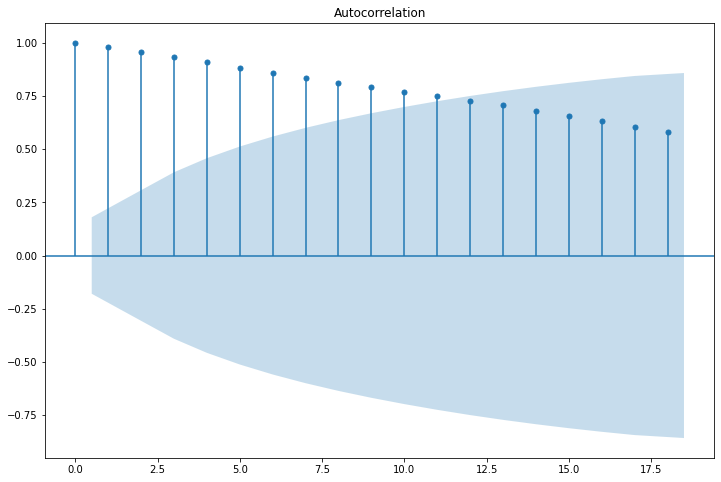

In [32]:
#ACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_acf(TTWO_monthly['natural_log'].iloc[1:], lags=18, ax=ax1)

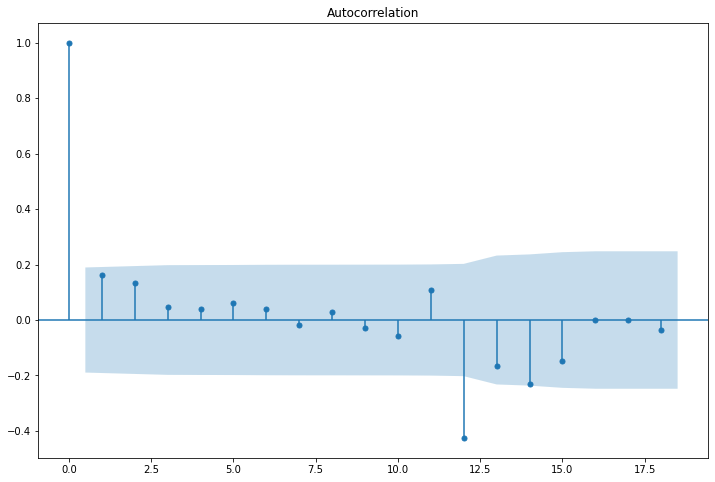

In [33]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_acf(TTWO_monthly['log_seasonal_first_difference'].iloc[13:], lags=18, ax=ax1)

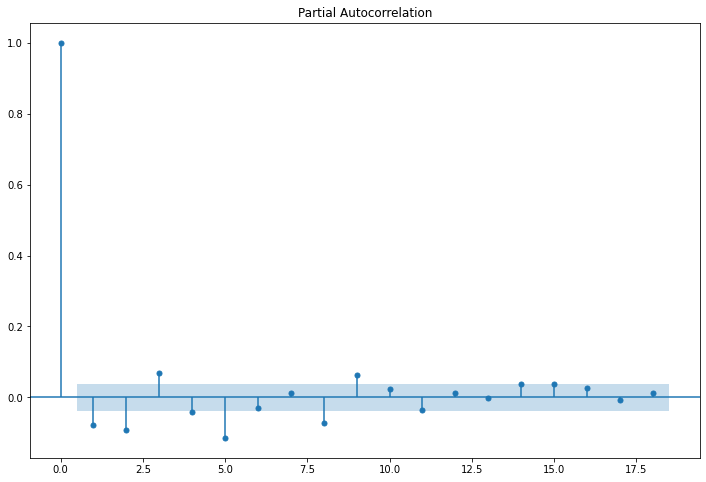

In [34]:
# Partial Correlation
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(TTWO['first_difference'].iloc[1:], lags=18, ax=ax1)

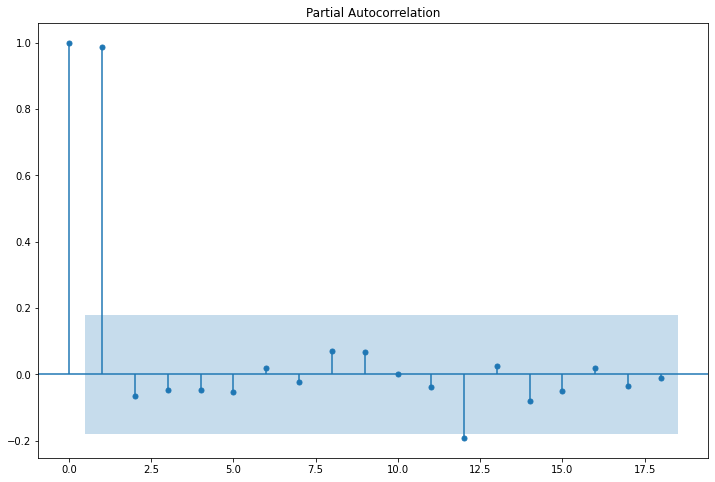

In [35]:
# Partial Correlation
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(TTWO_monthly['natural_log'].iloc[1:], lags=18, ax=ax1)

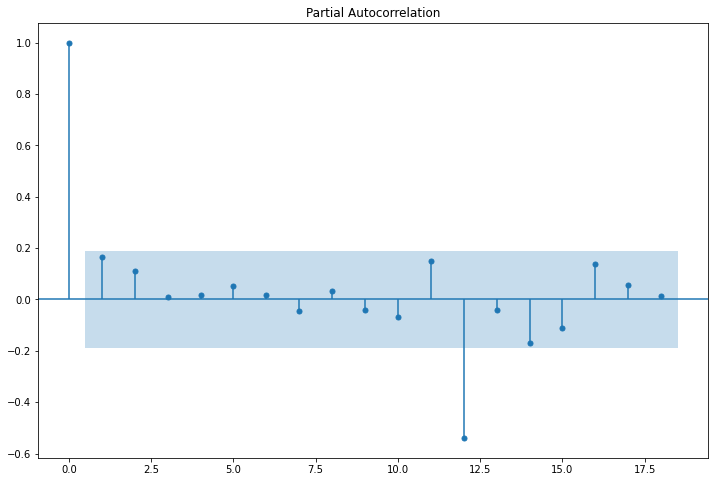

In [36]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_pacf(TTWO_monthly['log_seasonal_first_difference'].iloc[13:], lags=18, ax=ax1)

C:\Users\sdman\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

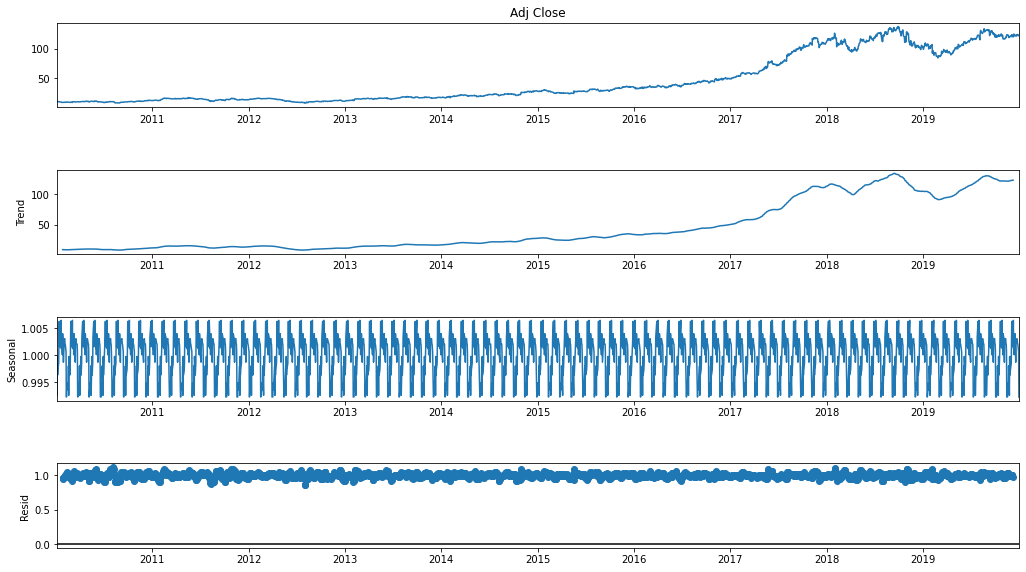

In [37]:
# Decomposition - Separating seasonality and trend from the model
result = seasonal_decompose(TTWO['Adj Close'].dropna(inplace=False), model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

<Figure size 432x288 with 0 Axes>

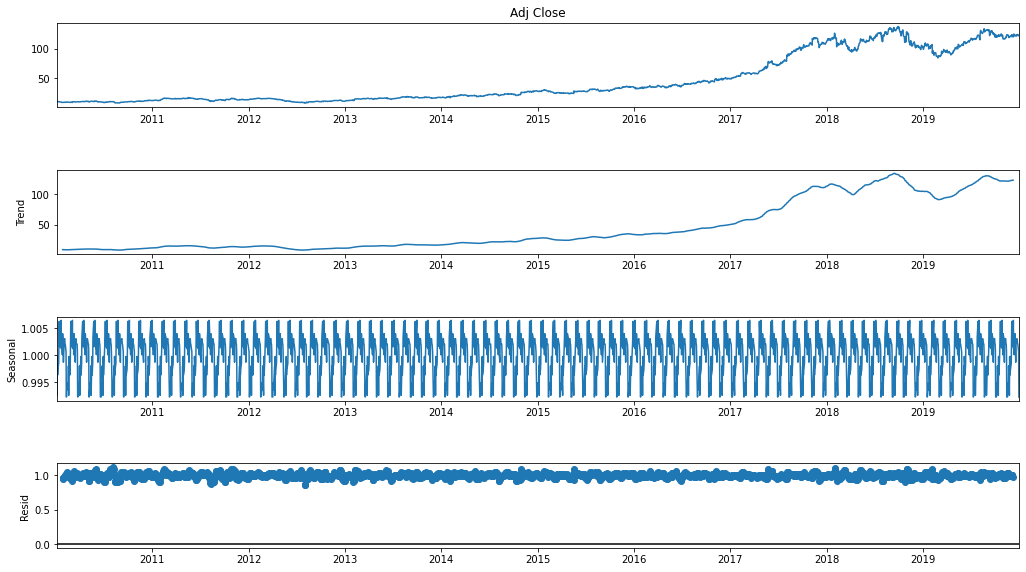

In [38]:
# Decomposition - Separating seasonality and trend from the model
result_month = seasonal_decompose(TTWO_monthly['Adj Close'].dropna(inplace=False), model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [54]:
# display(result_month.trend)
# display(result_month.seasonal)
# display(result_month.resid)

<Figure size 432x288 with 0 Axes>

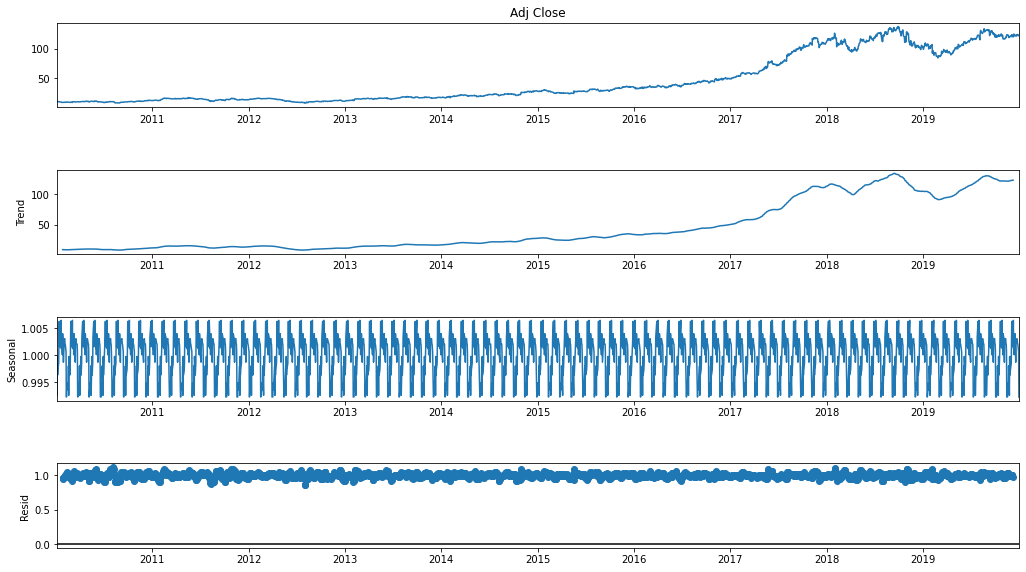

In [40]:
# Decomposition - Separating seasonality and trend from the model
result_log_first_diff = seasonal_decompose(TTWO_monthly['log_seasonal_first_difference'].dropna(inplace=False), model='additive', period= 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

The trend is showing a Exponential upward trend (generally)


In [41]:
# model = ARIMA(TTWO_monthly['Adj Close'].dropna(inplace=False), order=(2, 1, 1))
# results = model.fit()
# results.plot_predict(1, 210)

In [42]:
# Function to preform Auto ARIMA on timeseries
def arimamodel(timeseries):
    automodel = auto_arima(timeseries, 
                              start_p=0,        # the start value of the number of lags (0 lag)
                              start_q=0,        # the start point of the order of the moving-average
                              d=None,           # let model determine 'd'
                              test="adf",       # which test to run (Augmented Dickey Fuller) 
                              seasonal=False,   # No Seasonality
                              trace=True,
                              start_P=0, 
                              D=0,
                              error_action='ignore', 
                              suppress_warnings=True,
                              stationary=False,)
    
    #fit Auto Arima model to timeseries
#     fitted = automodel.fit(disp=-1)
    # Show SARIMAX Results
    print(automodel.summary())
    automodel.plot_diagnostics(figsize=(15,8))
    plt.show()
    return automodel

# Function to plot predicted values from arima and validation data
def plotarima(timeseries,fitted,valid_data,):
    
    # Forecast
    forecast, se , confidence_interval = fitted.forecast(len(valid_data), alpha=0.05)  # 95% confidence


    # Forecast series
    forecast_series = pd.Series(forecast, index=valid_data.index)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confidence_interval[:, 0], index=valid_data.index)
    upper_series = pd.Series(confidence_interval[:, 1], index=valid_data.index)
    
    # Create plot
    plt.figure(figsize=(15, 9))
    plt.grid(True)
    # Plot Training Data
    plt.plot(timeseries, label='Training Data')
    # Plot Forecast Data
    plt.plot(forecast_series, color="red",label='Predicted Stock Price')
    # Plot Validation data to check prediction
    plt.plot(valid_data,color='green',label='Validation Data')
    plt.xlabel('Time')
    plt.ylabel('Actual Stock Price')
    # Fill of Confidence Interval
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.05,
                     label="95% confidence interval")
    plt.title('Take-Two Interactive Software, Inc. Stock Price Forecast')
    plt.legend(loc="upper left")
    plt.show()

    
    y_true=valid_data
    y_pred=forecast_series[:len(valid_data)]
    # Mean Squared Error
    mse = mean_squared_error(y_true,y_pred)
    print(f"Model's Mean Squared Error: {mse}")
    # Mean Absolute Error
    mae = mean_absolute_error(y_true,y_pred)
    print(f"Model's Mean Absolute Error: {mae}")
    # Root Mean Squared Error
    rmse = mean_squared_error(y_true,y_pred,squared=False)
    print(f"Model's Root Mean Squared Error: {rmse}")
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
    print(f"Model's Mean Absolute Percentage Error: {mape}")
    # Accuracy of model
    print(f"Model's Accuracy: {(1.0-mape)*100}%")

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=675.605, BIC=681.163, Time=0.043 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=667.628, BIC=675.965, Time=0.051 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=670.884, BIC=679.222, Time=0.085 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=679.905, BIC=682.684, Time=0.018 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=665.062, BIC=676.179, Time=0.087 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=665.379, BIC=679.275, Time=0.117 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=662.015, BIC=675.911, Time=0.137 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=667.483, BIC=678.599, Time=0.079 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=663.985, BIC=680.659, Time=0.252 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=663.984, BIC=680.658, Time=0.205 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=666.588

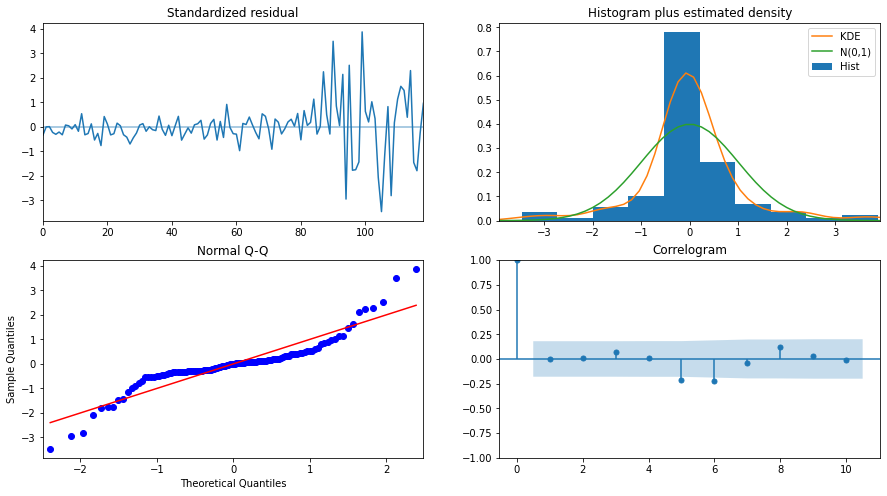

In [43]:
automodel = arimamodel(TTWO_monthly['Adj Close'].dropna(inplace=False))

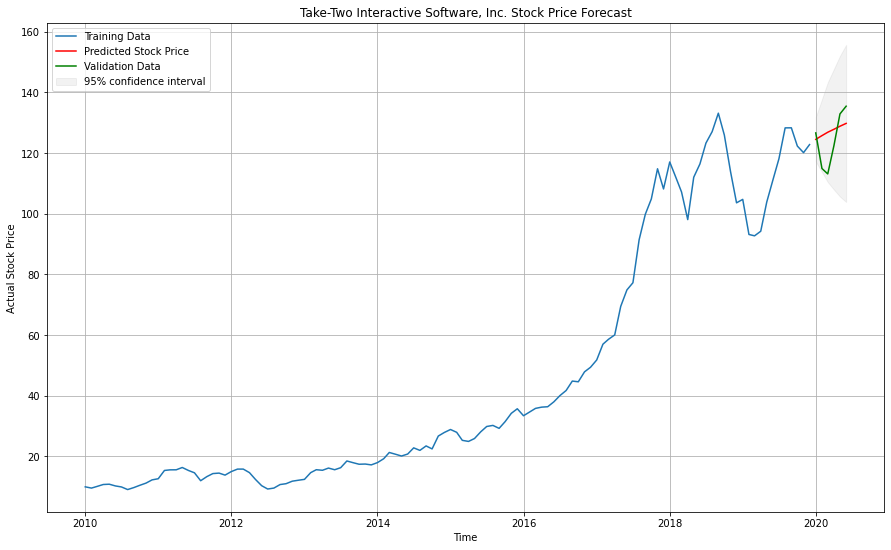

Model's Mean Squared Error: 64.7084329842469
Model's Mean Absolute Error: 6.965530955430204
Model's Root Mean Squared Error: 8.044155206374805
Model's Mean Absolute Percentage Error: 0.05814462638116128
Model's Accuracy: 94.18553736188387%


In [44]:
model = ARIMA(TTWO_monthly['Adj Close'], order=(2, 1, 1))   #order is found above in automodel SARIMAX(value)
fitted = model.fit(disp=-1)  
plotarima(TTWO_monthly['Adj Close'], fitted,valid_monthly['Adj Close'])

In [45]:
automodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -326.008
Date:                Wed, 19 May 2021   AIC                            662.015
Time:                        23:18:59   BIC                            675.911
Sample:                             0   HQIC                           667.658
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0515      0.671      1.567      0.117      -0.264       2.367
ar.L1         -0.4901      0.109     -4.516      0.000      -0.703      -0.277
ar.L2          0.3856      0.075      5.164      0.000       0.239       0.532
ma.L1          0.7833      0.102      7.642      0.000       0.582       0.984
sigma2        13.9901      1.072     13.056      0.000      11.890      16.090
===================================================================================
Ljung-Box (Q):                       50.58   Jarque-Bera (JB):                87.13
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):              28.93   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

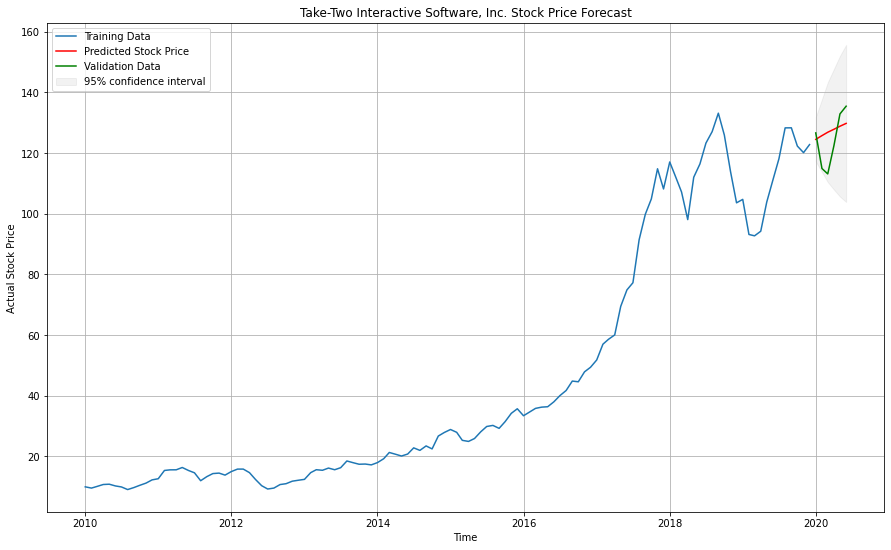

Model's Mean Squared Error: 64.7084329842469
Model's Mean Absolute Error: 6.965530955430204
Model's Root Mean Squared Error: 8.044155206374805
Model's Mean Absolute Percentage Error: 0.05814462638116128
Model's Accuracy: 94.18553736188387%


In [46]:
model = ARIMA(TTWO_monthly['Adj Close'], order=(2, 1, 1))   #order is found above in automodel SARIMAX(value)
fitted = model.fit(disp=-1)  
plotarima(TTWO_monthly['Adj Close'], fitted,valid_monthly['Adj Close'])

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8652.887, BIC=8664.547, Time=0.098 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=8639.249, BIC=8656.739, Time=0.274 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8636.138, BIC=8653.628, Time=0.413 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=8653.622, BIC=8659.452, Time=0.086 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8624.813, BIC=8648.133, Time=1.221 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=8612.517, BIC=8641.667, Time=1.491 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=8619.418, BIC=8642.738, Time=0.440 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=8610.932, BIC=8645.912, Time=1.288 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=8609.904, BIC=8639.054, Time=0.531 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=8607.809, BIC=8642.789, Time=0.725 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercep

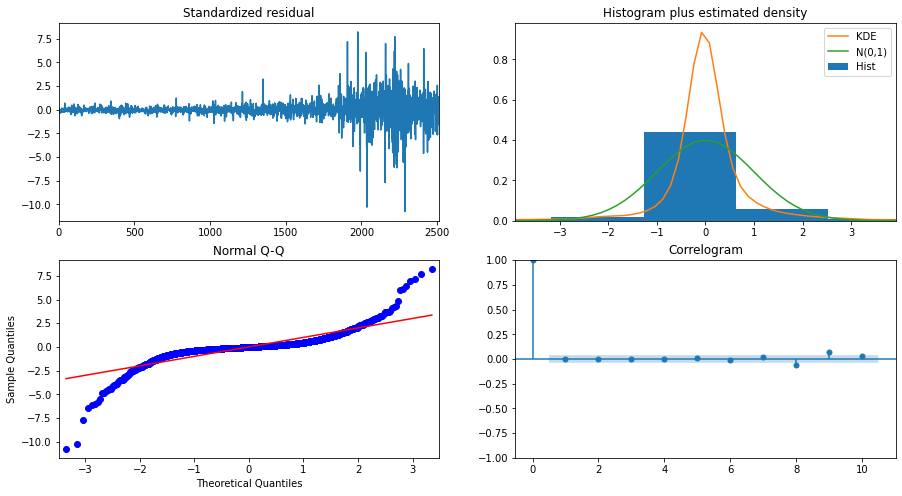

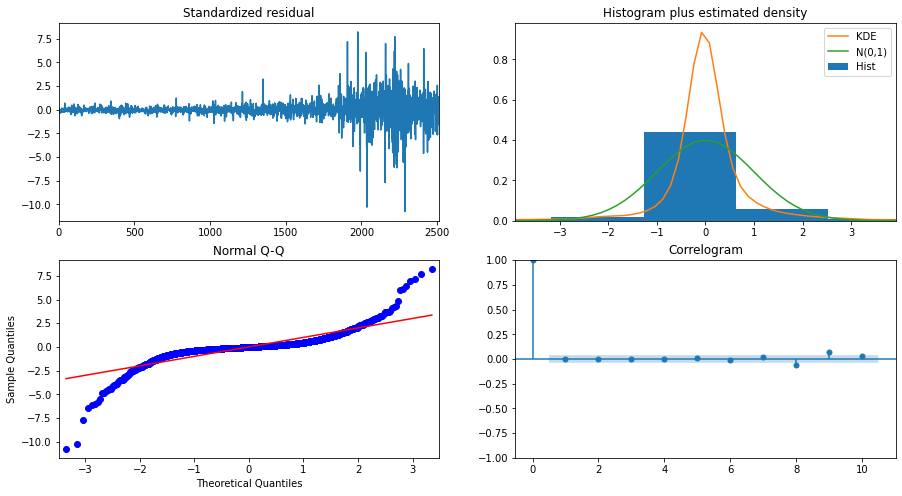

In [47]:
automodel2 = arimamodel(TTWO['Adj Close'].dropna(inplace=False))
# Residual plots from auto ARIMA
automodel2.plot_diagnostics(figsize=(15,8))
plt.show()


C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


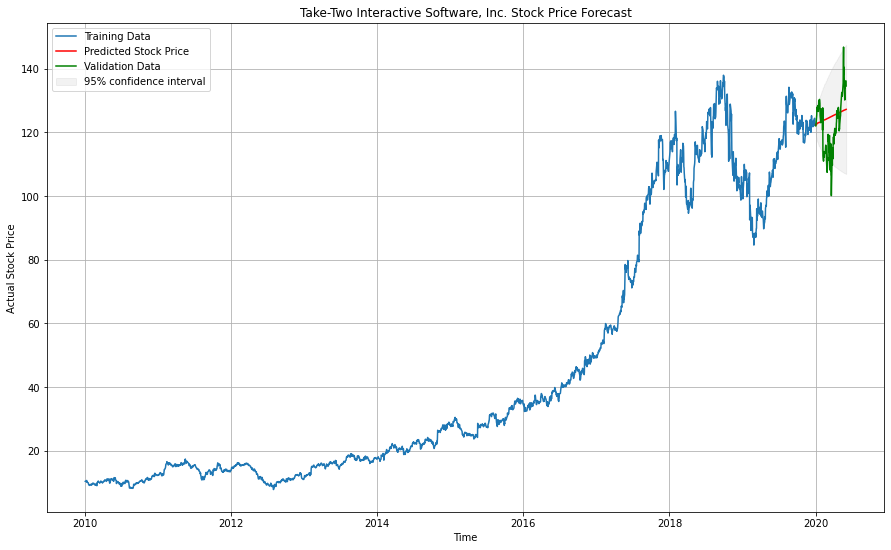

Model's Mean Squared Error: 78.32326159106886
Model's Mean Absolute Error: 7.198842267444053
Model's Root Mean Squared Error: 8.850043027639405
Model's Mean Absolute Percentage Error: 0.060920981404468874
Model's Accuracy: 93.9079018595531%


In [48]:
model = ARIMA(TTWO['Adj Close'],order=(5,1,1),)
fitted2 = model.fit(disp=-1)  
plotarima( TTWO['Adj Close'], fitted2,valid['Adj Close'])

In [49]:
# Forecast more in the future
def plot_forecast_arima(n_periods, timeseries, fitted, valid_data,):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, 
                                    return_conf_int=True)
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, freq="W")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    
    # Create plot
    plt.figure(figsize=(15, 9))
    plt.grid(True)
    # Plot Training Data
    plt.plot(timeseries, label='Training Data')
    # Plot Forecast Data
    plt.plot(fc_series, color="red",label='Predicted Stock Price')
    # Plot Validation data to check prediction
    plt.plot(valid_data,color='green',label='Validation Data')
    plt.xlabel('Time')
    plt.ylabel('Actual Stock Price')
    # Fill of Confidence Interval
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.05,
                     label="95% confidence interval")
    plt.title('Take-Two Interactive Software, Inc. Stock Price Forecast')
    plt.legend(loc="upper left")
    plt.show()

    


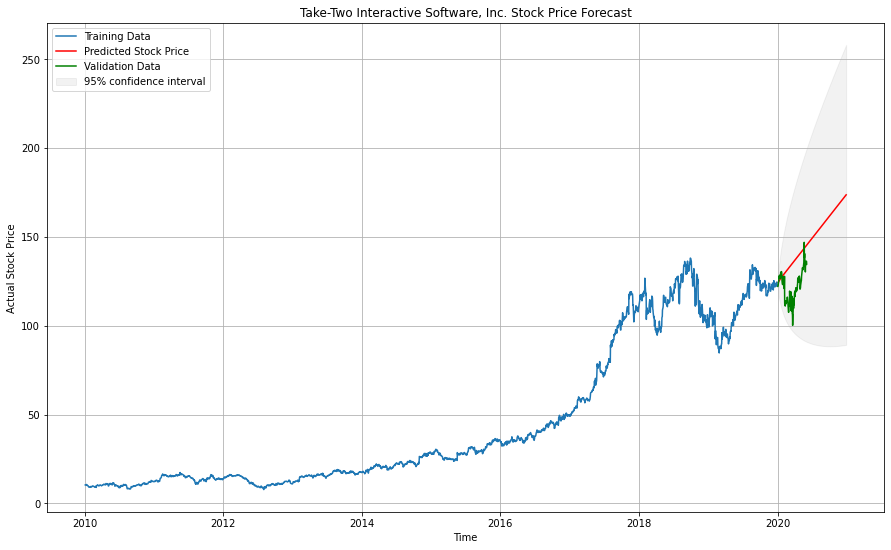

In [50]:
# forecast for the a year
plot_forecast_arima(52, TTWO['Adj Close'], fitted2, valid['Adj Close'])

# 

In [70]:
TTWO_df = TTWO.drop(columns='first_difference').copy()
TTWO_df.rename(columns={TTWO_df.Date:"ds",'Adj Close':'y'},inplace=True)
TTWO_df

AttributeError: 'DataFrame' object has no attribute 'Date'

In [57]:
m = Prophet()
m.fit(TTWO)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.